In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from torch_geometric.data import Data
import torch_geometric
import networkx as nx

from sklearn.model_selection import train_test_split

from ClusterDatasetTransformer import ClusterDataset
from training import *
from data_statistics import *

from IPython.display import display

from Transformer import Transformer
from lang import Lang
from LossFunction import Loss

2025-05-23 15:42:13.501146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 15:42:13.523290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748007733.549279   11074 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748007733.557093   11074 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 15:42:13.585393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
input_length = 60
max_seq_length = 60
batch_size = 64
max_nodes = 66

In [4]:
converter = Lang(max_nodes)
vocab_size = converter.n_words

In [5]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data/processed"
store_folder_training = "/eos/user/c/czeh/graph_data_trans"
data_folder_test = "/eos/user/c/czeh/graph_data_test/processed"
store_folder_test = "/eos/user/c/czeh/graph_data_trans_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(converter, store_folder_training, data_folder_training, max_nodes=max_nodes, input_length=input_length)
dataset_test = ClusterDataset(converter, store_folder_test, data_folder_test, max_nodes=max_nodes, input_length=input_length)

In [6]:
train_dl = DataLoader(dataset_training, shuffle=True, batch_size=batch_size)
test_dl = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [13]:
epochs = 100
d_model = 16
num_heads = 2
num_layers = 4
d_ff = 32
dropout = 0
padding = converter.word2index["<PAD>"]
feature_num = len(dataset_test.model_feature_keys)

# Model, loss, and optimizer
model = Transformer(padding, vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
# criterion = Loss(converter)

In [14]:
# Optionally introduce weight decay
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [15]:
# weights = torch.load("/eos/user/c/czeh/tranformer_2.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

In [23]:
train_loss_hist = []
val_loss_hist = []

In [24]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[:n-1] = a[:n-1]
    ret[n - 1:] = ret[n - 1:] / n
    return ret

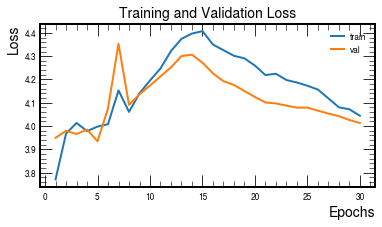

training: 100%|██████████| 151/151 [03:08<00:00,  1.25s/it]


Epoch 1, Loss: nan


test: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Epoch 1, Val Loss: 3.993131
Epoch 1, LR: 0.000125


training:   0%|          | 0/151 [00:00<?, ?it/s]


KeyboardInterrupt: 

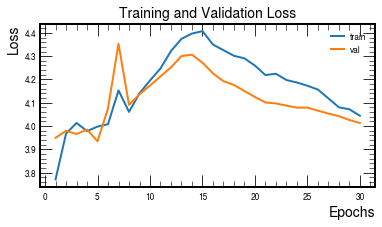

In [27]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
# Optionally introduce gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25)

#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 10

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

display_loss = display(1, display_id=True)

optimizer.zero_grad()
# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    val_loss = 0
    
    for sample in tqdm(train_dl, desc="training"):
        output = model(sample[0].to(device), sample[1].to(device))
        
        losses = np.zeros(sample[2].shape[1])
        for y in range(sample[2].shape[1]):
            loss = criterion(output.contiguous().view(-1, vocab_size)-padding, (sample[2][:, y]-padding).contiguous().view(-1).to(device))
            losses[y] = loss.item()
            
        loss.backward(retain_graph=True)
        total_loss += np.mean(losses)
        
        optimizer.step()
        
    loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
    train_loss_hist.append(loss)
    model.eval()
    for sample in tqdm(test_dl, desc="test"): 
        output = model(sample[0].to(device), sample[1].to(device))
#         loss = criterion(output.contiguous().view(-1, vocab_size)-padding, (sample[2]-padding).to(device))

        losses = np.zeros(sample[2].shape[1])
        for y in range(sample[2].shape[1]):
            loss = criterion(output.contiguous().view(-1, vocab_size)-padding, (sample[2][:, y]-padding).contiguous().view(-1).to(device))
            losses[y] = loss.item()
        val_loss +=  np.mean(losses)

        optimizer.step()
    val_loss = val_loss / len(test_dl)
    print(f"Epoch {epoch+1}, Val Loss: {loss:.6f}")
    val_loss_hist.append(val_loss)
    
    ax_loss.clear()
    plot_loss(moving_average(train_loss_hist, 8), moving_average(val_loss_hist, 8), ax=ax_loss)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    scheduler.step()
    print(f"Epoch {epoch+1}, LR: {scheduler.get_last_lr()[0]}")
        
        
        
    # Early stopping
#     if loss < best_loss:
#         best_loss = val_loss
#         best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
#         patience = 10  # Reset patience counter
#     else:
#         patience -= 1
#         if patience == 0:
#             break
            
# Load the best model weights
# model.load_state_dict(best_model_weights)

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
epochs = len(train_loss_hist)
ax.plot(range(1, epochs+1), moving_average(train_loss_hist, 8), label='train', linewidth=2)
ax.plot(range(1, epochs+1), moving_average(val_loss_hist, 8), label='val', linewidth=2)
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)
ax.set_title("Training and Validation Loss", fontsize=14)
ax.legend()

In [ ]:
# correct = 0
# model.eval() 
# torch.no_grad()
# i = 0
# for sample in tqdm(test_dl, desc="test"):
#     input_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
#     target_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
#     edge_tensor = torch.zeros((1, sample.x.shape[0], feature_num), dtype=torch.float).to(device)

#     input_tensor[0, :] = torch.tensor(sample[i].input, dtype=torch.long)
#     target_tensor[0, :] = torch.tensor(sample[i].y_trans, dtype=torch.long)
#     edge_tensor[0, :] = torch.unsqueeze(sample.x, dim=0).float()
            
#     predictions = model(edge_tensor, input_tensor)
#     predicted_index = predictions.argmax(-1)
#     predicted_number = predicted_index[0, -1].item()
# #     res = torch.roll(input_tensor, predicted_number, dims=1)

# #     step = 0
# #     while (predicted_number != 2 and step < 100):  # Disable gradient computation for inference
# #         input_tensor = torch.roll(input_tensor, -1, dims=1)
# #         input_tensor[0, -1] = predicted_number
    
# #         predictions = model(edge_tensor, input_tensor)
# #         predicted_index = predictions.argmax(-1)  # Get the index of the max log-probability for the last position
# #         predicted_number = predicted_index[0, -1].item()  # Convert to Python number
# #         res.append(predicted_number)
# #         step += 1
     
# #     input_tensor = torch.roll(input_tensor, -1, dims=1)
# #     input_tensor[0, -1] = predicted_number 
# #     check = converter.arr2seq(input_tensor[0]) == converter.arr2seq(converter.subseq2arr(sample[0].y, input_length, 0, input_length))
    
#     print(f"Input Sequence: {sample[0].input}")
#     print(f"Predicted: {predicted_number}")
#     print(f"Real: {sample[i].y_trans[-1]}")
# #     print(f"Predicted Sequence: {converter.seq2y(np.array(res.cpu()))}")
# #     print(f"Correct: {check}")
    
# #     try:
# #         origG = torch_geometric.utils.to_networkx(sample, to_undirected=True)
# #         res_nodes, res_edges = sequenceToGraph(converter.arr2seq(input_tensor[0], ignoreTokens=True))
# #         newData = Data(x=sample.x, num_nodes=sample.num_nodes, edge_index=torch.from_numpy(res_edges))
# #         G = torch_geometric.utils.to_networkx(newData, to_undirected=True)

# #         fig, ax = plt.subplots(1, 2)
# #         nx.draw_circular(origG, with_labels=True, ax=ax[0])
# #         nx.draw_circular(G, with_labels=True, ax=ax[1])
# #     except:
# #         print("incorrect sequence")
    
    
# #     correct += check

# # print(f"Percentage of correct guesses: {correct / (len(test_dl))}")

In [ ]:
torch.save({'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': loss
            }, "/eos/user/c/czeh/tranformer_4.pt")


## Test Full Event

In [ ]:
from EventGrouping import EventGrouping

In [ ]:
model2 = Transformer(padding, vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
weights = torch.load("/eos/user/c/czeh/tranformer_4.pt", weights_only=True)
model2.load_state_dict(weights["model_state_dict"])

In [ ]:
runner = EventGrouping(converter, model2, neighborhood=1, seq_length=input_length)
runner(dataset_test.get(0))

In [ ]:
model_feature_keys = np.array([0,  2,  3,  4,  6,  7, 10, 14, 15, 16, 17, 18, 22, 24, 25, 26, 28, 29])
dataset_training.__getitem__(0)[0][:, model_feature_keys][:, -1]

In [ ]:
dataset_test.get(0).cluster

In [ ]:
dataset_training.node_feature_keys[16]

In [ ]:
G = torch_geometric.utils.to_networkx(dataset_test.get(0), to_undirected=True)

In [ ]:
dataset_training.get(0).x[:, 16]

In [ ]:
fig, ax = plt.subplots(1, 1)
nx.draw(G, with_labels=True, ax=ax)

In [ ]:
dataset_training.get(1).roots